# Advanced Lane Finding

## Import libraries

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import glob
import os

In [107]:
out_dir = 'output_images/'

# Utility method to save images
def save_img(img, name):
    rbg_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(out_dir+name, rbg_img)


## Load Camera Calibration Images

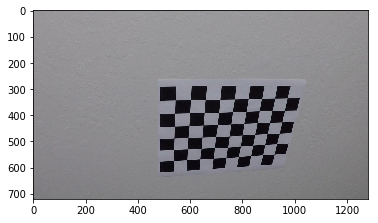

In [108]:
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Print an example
example_img = mpimg.imread(cal_images[16])
plt.imshow(example_img)

In [109]:
# Object points - points in 3D world
obj_points = []

# Image points - points in 2D world on flat surface
img_points = []

# Prepare object points (9x6 chessboard)
# (x, y, z)
# (0, 0, 0), (1, 0, 0) ... (8, 5, 0)

# Create array of 9x6 points with 3 points x,y,z each
objp = np.zeros((9*6, 3), np.float32)

# Assign proper points values to objp
# Z coordinate will remain zero always
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)


camera_cal/calibration3.jpg
Total images with corners: 17
17
17


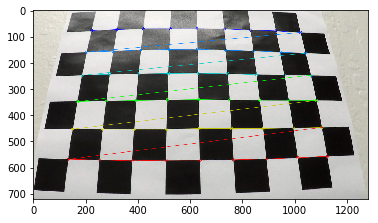

In [110]:
# Calculating Image points from image using openCV

count = 0
for img_path in cal_images:
    # Read each image
    img = mpimg.imread(img_path)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # Are corners found?
    if ret == True:
        
        # Add image and object points for each image found having corners
        obj_points.append(objp)
        img_points.append(corners)
        
        # Draw image, corners for one image
        if count == 2:
            corner_img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            print(img_path)
            plt.figure()
            plt.imshow(img)
            cv2.imwrite(out_dir+'draw_corners.jpg', img)
        
        # Increase count only for images with corners found
        count = count + 1

print('Total images with corners: {}'.format(count))
print(len(obj_points))
print(len(img_points))

## Calibrate Camera using Image and Object points

In [111]:
# Calibrate camera
# mtx = Camera matrix
# dist = Distortion Coefficients

ret, mtx, dist, rvects, tvects = cv2.calibrateCamera(obj_points, img_points, example_img.shape[1::-1], None, None)

## Undistort an image

True

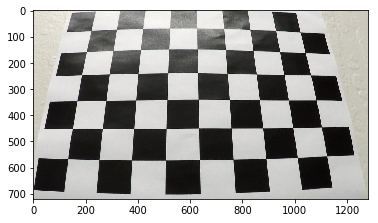

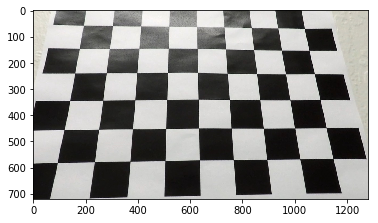

In [112]:
# Undistort image fucntion
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Undistort example image
example_img = mpimg.imread(cal_images[4])
plt.figure()
plt.imshow(example_img)
cv2.imwrite(out_dir+'distorted_img.jpg', example_img)

undist_img = undistort_img(example_img, mtx, dist)
plt.figure()
plt.imshow(undist_img)
cv2.imwrite(out_dir+'un_distorted_img.jpg', undist_img)

## Undistort Test Images

['test_images/test6.jpg', 'test_images/test5.jpg', 'test_images/test4.jpg', 'test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test2.jpg', 'test_images/straight_lines2.jpg', 'test_images/straight_lines1.jpg']


True

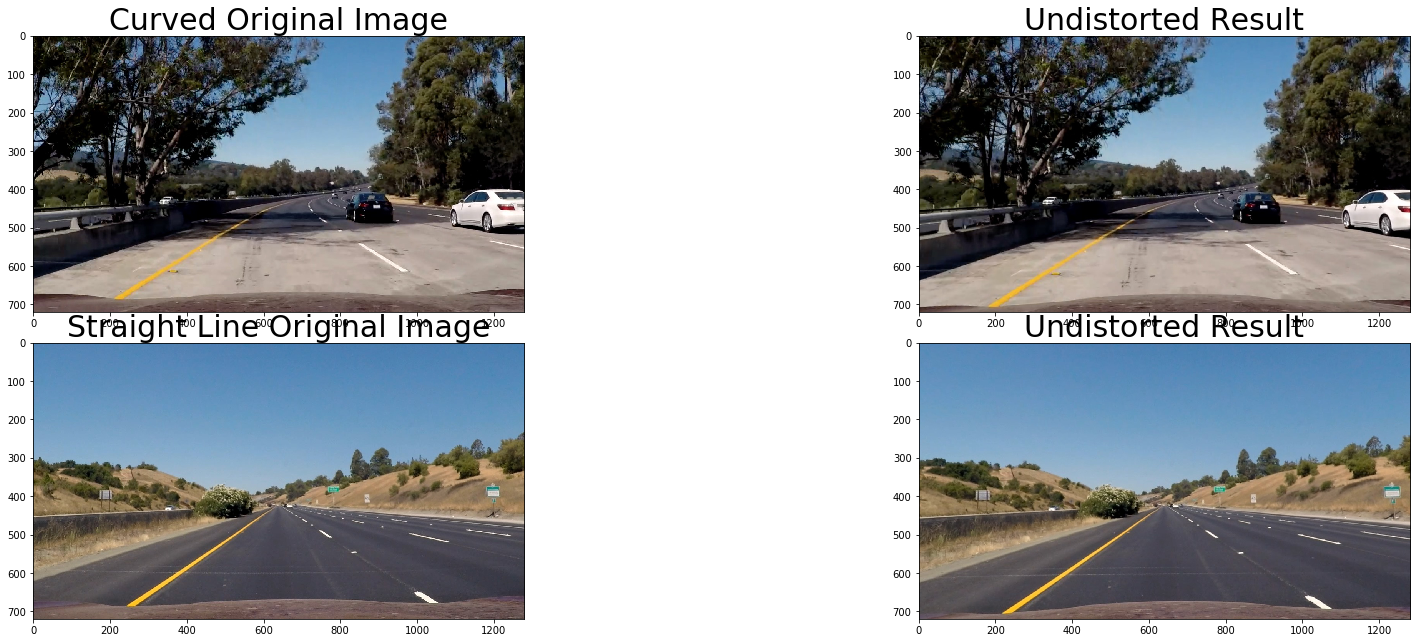

In [113]:
# Read all test images
test_img_dir = 'test_images/'
images = os.listdir(test_img_dir)
test_images = []

# Append image directory to all files
for img in images:
    test_images.append(test_img_dir + img)

# Print test image
print(test_images)
curved_img = mpimg.imread(test_images[1])
straight_line_img = mpimg.imread(test_images[7])

f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

axes[0,0].imshow(curved_img)
axes[0,0].set_title('Curved Original Image', fontsize=30)

undistort_curved_result = undistort_img(curved_img, mtx, dist)

axes[0,1].imshow(undistort_curved_result)
axes[0,1].set_title('Undistorted Result', fontsize=30)

axes[1,0].imshow(straight_line_img)
axes[1,0].set_title('Straight Line Original Image', fontsize=30)

undistort_straight_result = undistort_img(straight_line_img, mtx, dist)

axes[1,1].imshow(undistort_straight_result)
axes[1,1].set_title('Undistorted Result', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#cv2.imwrite(out_dir+'curved_original_img.jpg', curved_img)
save_img(curved_img, 'curved_original_img.jpg')
cv2.imwrite(out_dir+'curved_undistorted_img.jpg', undistort_curved_result)
cv2.imwrite(out_dir+'straight_original_img.jpg', straight_line_img)
cv2.imwrite(out_dir+'straight_undistorted_img.jpg', undistort_straight_result)

## Compute Color and Gradient Threshold

In [114]:
def pipeline(image, s_color_thres=(170, 255), l_color_thres=(180, 250), gradient_thres=(17, 120), kernel_size=3):
    img = np.copy(image)
    
    # Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # Extract H, L and S channels
    h_channel = hls_img[:,:,0]
    l_channel = hls_img[:,:,1]
    s_channel = hls_img[:,:,2]
    
    ################################
    # H-Channel
    ################################
    # Create an array like H-channel
    h_color_binary = np.zeros_like(h_channel)
    
    # Set pixel points to 1 where H-channel is between thresholds
    h_color_binary[(h_channel >= 20) & (h_channel <= 30)] = 1
    
    
    ################################
    # S-Channel
    ################################
    # Create an array like S-channel
    s_color_binary = np.zeros_like(s_channel)
    
    # Set pixel points to 1 where S-channel is between thresholds
    s_color_binary[(s_channel >= s_color_thres[0]) & (s_channel <= s_color_thres[1])] = 1
    
    ################################
    # L-Channel
    ################################
    # Create an array like S-channel
    l_color_binary = np.zeros_like(l_channel)
    
    # Set pixel points to 1 where S-channel is between thresholds
    l_color_binary[(l_channel >= l_color_thres[0]) & (l_channel <= l_color_thres[1])] = 1
    
    
    ###################################
    # Now calculate gradient thresholds
    ###################################
    
    # Convert to Grayscale color space
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradient in X direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8( (255*abs_sobelx) / np.max(abs_sobelx) )
    
    # Calculate gradient in Y direction
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8( (255*abs_sobely) / np.max(abs_sobely) )
    
    sxbinary = np.zeros_like(scaled_sobelx)
    sybinary = np.zeros_like(scaled_sobely)
    
    sxbinary[(scaled_sobelx >= gradient_thres[0]) & (scaled_sobelx <= gradient_thres[1])] = 1
    sybinary[(scaled_sobely >= gradient_thres[0]) & (scaled_sobely <= gradient_thres[1])] = 1
    
    
    #####################
    # Magnitude gradient
    #####################
    
    #magnitude = np.sqrt(sobelx**2 + sobely**2)
    #scaled_mag = np.uint8( (255*magnitude) / np.max(magnitude) )
    
    #mag_binary = np.zeros_like(scaled_mag)
    #mag_binary[(scaled_mag >= 25) & (scaled_mag <= 100)] = 1
    
    
    #####################
    # Directional gradient
    #####################
    #dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    
    #dir_binary = np.zeros_like(dir_gradient)
    #dir_thresh = (0.99, (np.pi/2))
    #dir_binary[(dir_gradient >= dir_thresh[0]) & (dir_gradient <= dir_thresh[1])] = 1
    
    # Combined binary for gradient thresholds
    gradient_binary = np.zeros_like(sxbinary)
    gradient_binary[ ( (sxbinary == 1) & (sybinary == 1) )] = 1
    
    
    ######################################
    # Combined color and threshold binary
    ######################################
    combined_binary = np.zeros_like(gradient_binary)
    #combined_binary[(gradient_binary == 1) | (s_color_binary == 1) | (h_color_binary == 1)] = 1
    combined_binary[(gradient_binary == 1) | (s_color_binary == 1)] = 1

    '''
    f, axes = plt.subplots(2, 2, figsize=(24, 9))
    f.tight_layout()
    
    axes[0,0].imshow(h_color_binary, cmap='gray')
    axes[0,0].set_title('h_color_binary', fontsize=40)
    
    axes[0,1].imshow(s_color_binary, cmap='gray')
    axes[0,1].set_title('s_color_binary', fontsize=40)
    
    axes[1,0].imshow(gradient_binary, cmap='gray')
    axes[1,0].set_title('gradient_binary', fontsize=40)
    
    axes[1,1].imshow(combined_binary, cmap='gray')
    axes[1,1].set_title('combined_binary', fontsize=40)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    '''
    return combined_binary

In [115]:
threshold_straight_image = pipeline(undistort_straight_result)

In [116]:
threshold_curved_image = pipeline(undistort_curved_result)

## Perspective transform

In [117]:
# Store the src points for straight line image

def warp_image(img):
    
    # Four source points
    src = np.float32([[335, 628], [484, 526], [800, 526], [956, 628]])
    (y, x) = img.shape[0], img.shape[1]
    
    dst = np.float32([ [x/4, y], [x/4, y/5], [(3*x)/4, y/5], [(3*x)/4, y] ])
    
    # Get the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp the image
    warped_img = cv2.warpPerspective(img, M, (x, y))

    return warped_img, Minv

True

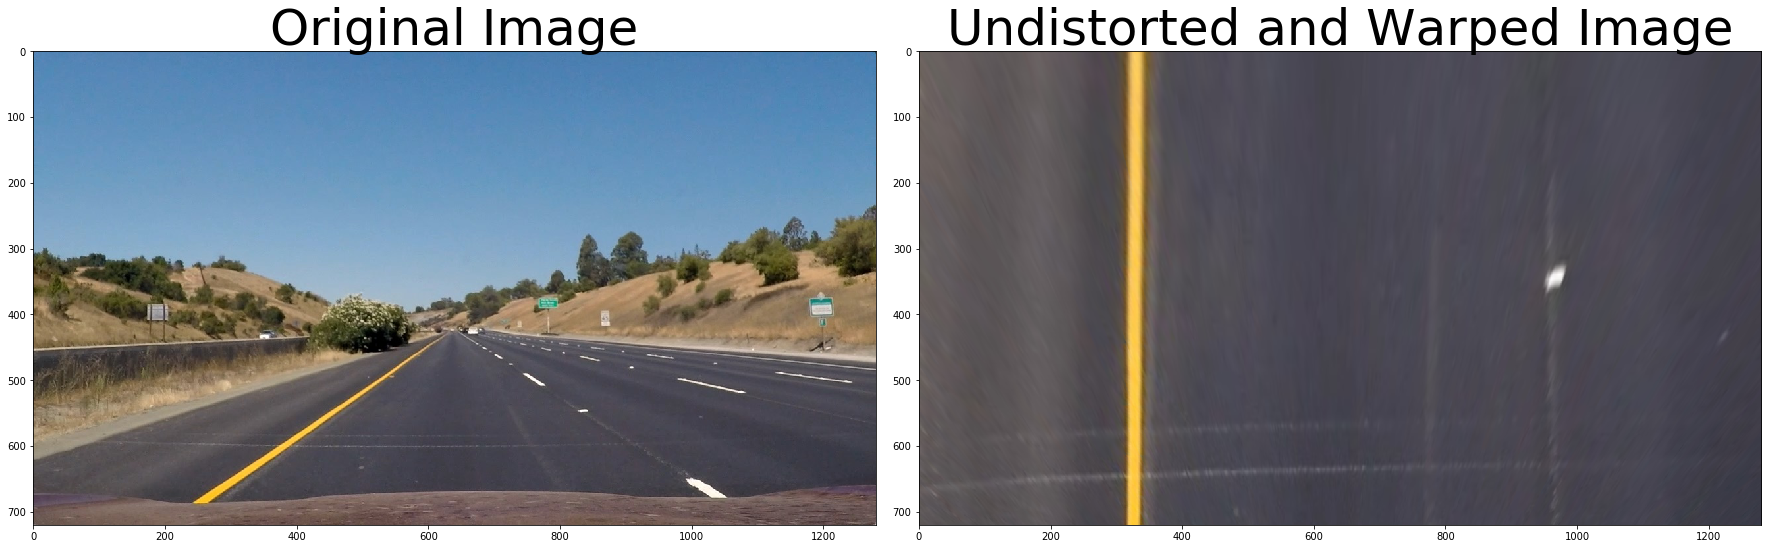

In [118]:
warped_straight_img, Minv = warp_image(undistort_straight_result)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(straight_line_img)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(warped_straight_img)
ax2.set_title('Undistorted and Warped Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite(out_dir+'straight_undistorted_warped_img.jpg', warped_straight_img)

True

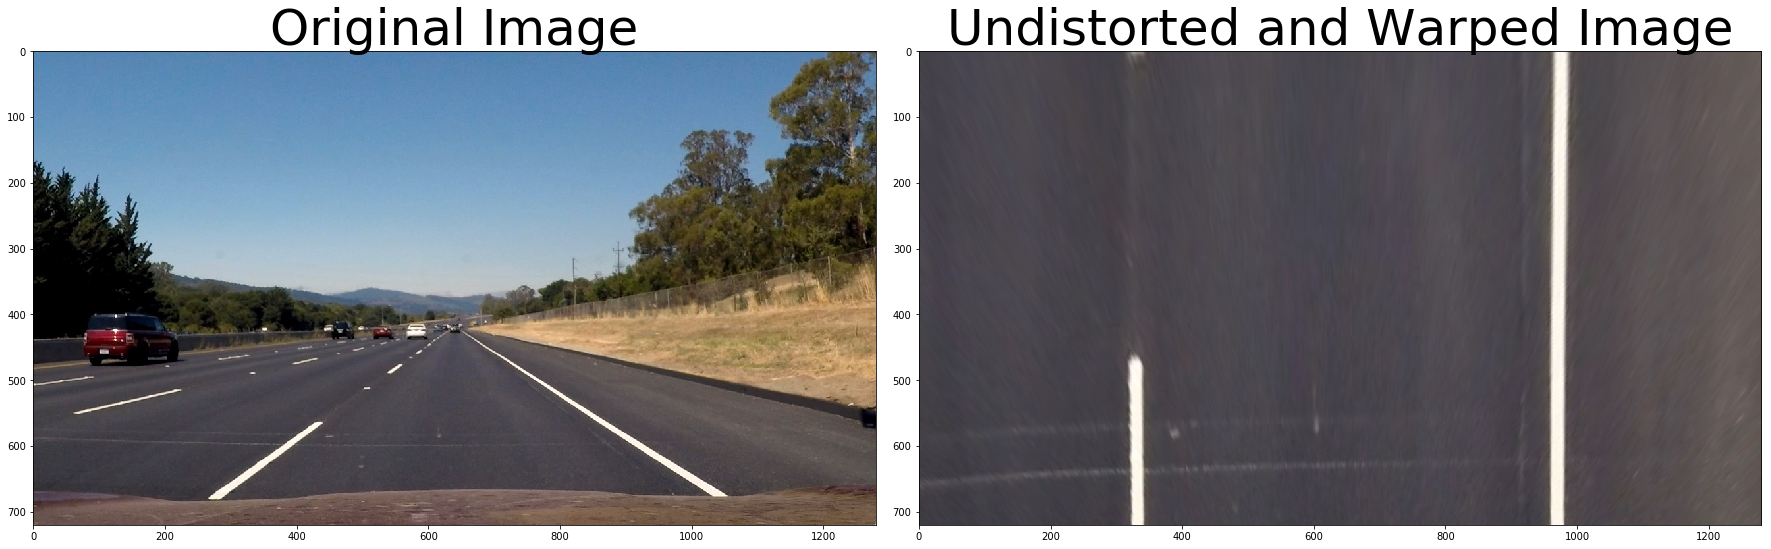

In [119]:
# Try warping on second straight line image
straight_img_2 = mpimg.imread(test_img_dir + 'straight_lines2.jpg')
straight_img_undistort_2 = undistort_img(straight_img_2, mtx, dist)

warped_straight_2_img, Minv = warp_image(straight_img_undistort_2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(straight_img_2)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(warped_straight_2_img)
ax2.set_title('Undistorted and Warped Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite(out_dir+'straight2_original_img.jpg', straight_img_2)
cv2.imwrite(out_dir+'straight2_undistorted_warped_img.jpg', warped_straight_2_img)

True

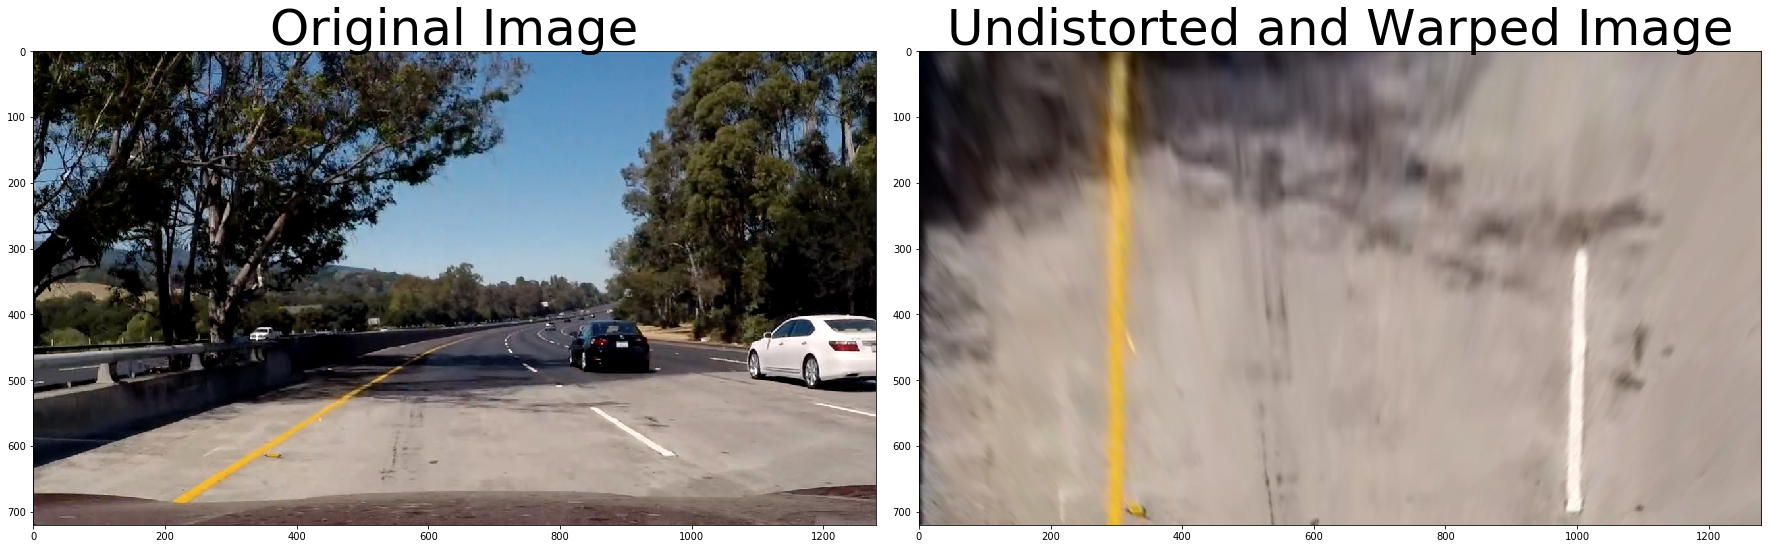

In [120]:
# Try warping on curved line image

warped_curve_2_img, Minv = warp_image(undistort_curved_result)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(curved_img)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(warped_curve_2_img)
ax2.set_title('Undistorted and Warped Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite(out_dir+'curved_original_img.jpg', curved_img)
cv2.imwrite(out_dir+'curved_undistorted_warped_img.jpg', warped_curve_2_img)

"\ncv2.imwrite(out_dir+'curved_thresholded_img.jpg', threshold_curved_image)\n#cv2.imwrite(out_dir+'curved_thresholded_warped_img.jpg', warped_curve_2_img)\n\nsave_img(warped_curve_2_img, 'curved_thresholded_warped_img.jpg')\n"

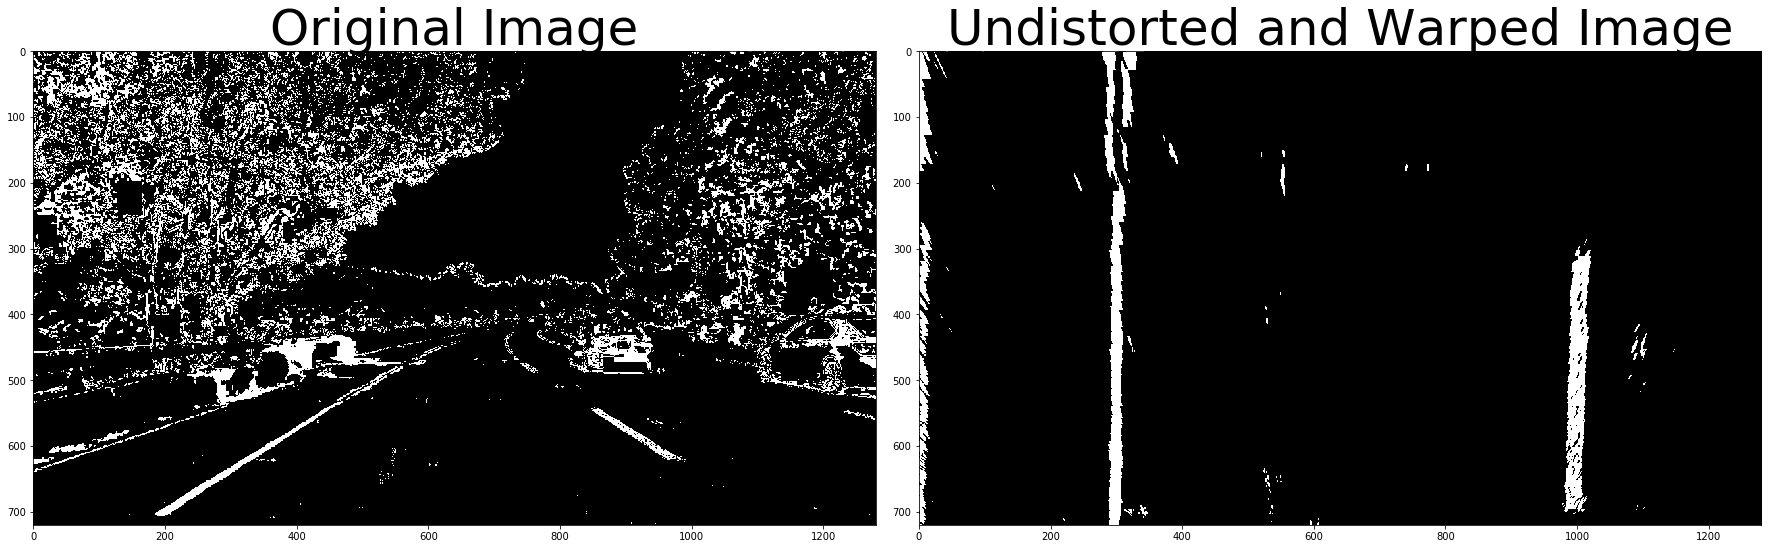

In [121]:
# Try warping on curved threshold line image

warped_curve_2_img, Minv = warp_image(threshold_curved_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(threshold_curved_image, cmap='gray')
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(warped_curve_2_img, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''
cv2.imwrite(out_dir+'curved_thresholded_img.jpg', threshold_curved_image)
#cv2.imwrite(out_dir+'curved_thresholded_warped_img.jpg', warped_curve_2_img)

save_img(warped_curve_2_img, 'curved_thresholded_warped_img.jpg')
'''

## Finding the lines

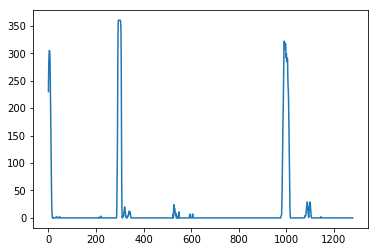

In [122]:
# Create a histogram from thresholded warped image

def get_histogram(img):
    # Histogram for all columns of half of image

    histogram = np.sum(img[(img.shape[0]//2):,:], axis=0)
    
    return histogram

histogram_curve_img = get_histogram(warped_curve_2_img)
plt.plot(histogram_curve_img)


#plt.imsave(out_dir+'curved_thresholded_warped_histogram_img.jpg', histogram_curve_img)
#save_img(histogram_curve_img, 'curved_thresholded_warped_histogram_img.jpg')

## Sliding window to find lane lines

In [125]:
def fit_lane_lines_from_warped(img):

    histogram = get_histogram(img)
    
    # create an output image to work on
    out_image = np.dstack((img, img, img))*255

    # Find the peak in the left and right part of historgram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 9

    # Get the height of each window
    window_height = np.int(img.shape[0]/nwindows)
    
    # Get all positions of (x, y) points with non-zero pixel values
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current pixels to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Width of the window +/- margin
    margin = 100 #pixels
    
    # Minimum number of pixels required to recenter window
    minpix = 50
    
    #Empty lists to receive left and right lane pixel index
    left_index = []
    right_index = []
    
    
    # Step through each window
    for window in range(nwindows):
        
        # Identify window boundaries in left and right lane
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - (window)*window_height
        
        winx_x_left_lane_left = leftx_current - margin
        winx_x_left_lane_right = leftx_current + margin
        winx_x_right_lane_left = rightx_current - margin
        winx_x_right_lane_right = rightx_current + margin
        
        # Draw the windows on the image
        # Left lane window
        # ----------- Vis image----------(left low point)--------------(right up point)---------------------color----size--
        cv2.rectangle(out_image, (winx_x_left_lane_left, win_y_low), (winx_x_left_lane_right, win_y_high), (0, 255, 0), 3)
        
        # Right lane window
        cv2.rectangle(out_image, (winx_x_right_lane_left, win_y_low), (winx_x_right_lane_right, win_y_high), (0, 255, 0), 3)
        

        #Identify non-zero pixels in these windows
        good_left_index = ( (nonzeroy >=  win_y_low) 
                           & (nonzeroy <  win_y_high) 
                           & (nonzerox >= winx_x_left_lane_left) 
                           & (nonzerox < winx_x_left_lane_right) ).nonzero()[0]
        
        good_right_index = ( (nonzeroy >=  win_y_low) 
                           & (nonzeroy <  win_y_high) 
                           & (nonzerox >= winx_x_right_lane_left) 
                           & (nonzerox < winx_x_right_lane_right) ).nonzero()[0]
        
        # Add these indices to list
        left_index.append(good_left_index)
        right_index.append(good_right_index)
        
        # If no of pixels in the above window were greater that min pixels, recenter next window to mean pos
        if len(good_left_index) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_index]))
            
        if len(good_right_index) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_index]))
    
    
    # Concatenate the arrays of indices
    left_index = np.concatenate(left_index)
    right_index = np.concatenate(right_index)
    
    #Extract left and right lane pixels
    leftx = nonzerox[left_index]
    lefty = nonzeroy[left_index]
    
    rightx = nonzerox[right_index]
    righty = nonzeroy[right_index]
    
    
    # Fit a second order polynomial through left and right points
    left_poly = np.polyfit(lefty, leftx, 2)
    right_poly = np.polyfit(righty, rightx, 2)
    
    
    # Draw the polynomials generated on image
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    #Equation of second order polynomial
    left_poly_x = left_poly[0]*ploty**2 + left_poly[1]*ploty + left_poly[2]
    right_poly_x = right_poly[0]*ploty**2 + right_poly[1]*ploty + right_poly[2]
    
    '''
    # Color the left and right image points to red and blue respectively
    out_image[lefty, leftx] = [255, 0, 0]
    out_image[righty, rightx] = [0, 0, 255]
    
    # Finally draw the image
    plt.imshow(out_image)
    
    # Draw the polynomial lines as well
    plt.plot(left_poly_x, ploty, color='yellow')
    plt.plot(right_poly_x, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    
    return left_poly, right_poly

In [126]:
left_poly, right_poly = fit_lane_lines_from_warped(warped_curve_2_img)

## Skip Sliding Window - Do local search for lane lines

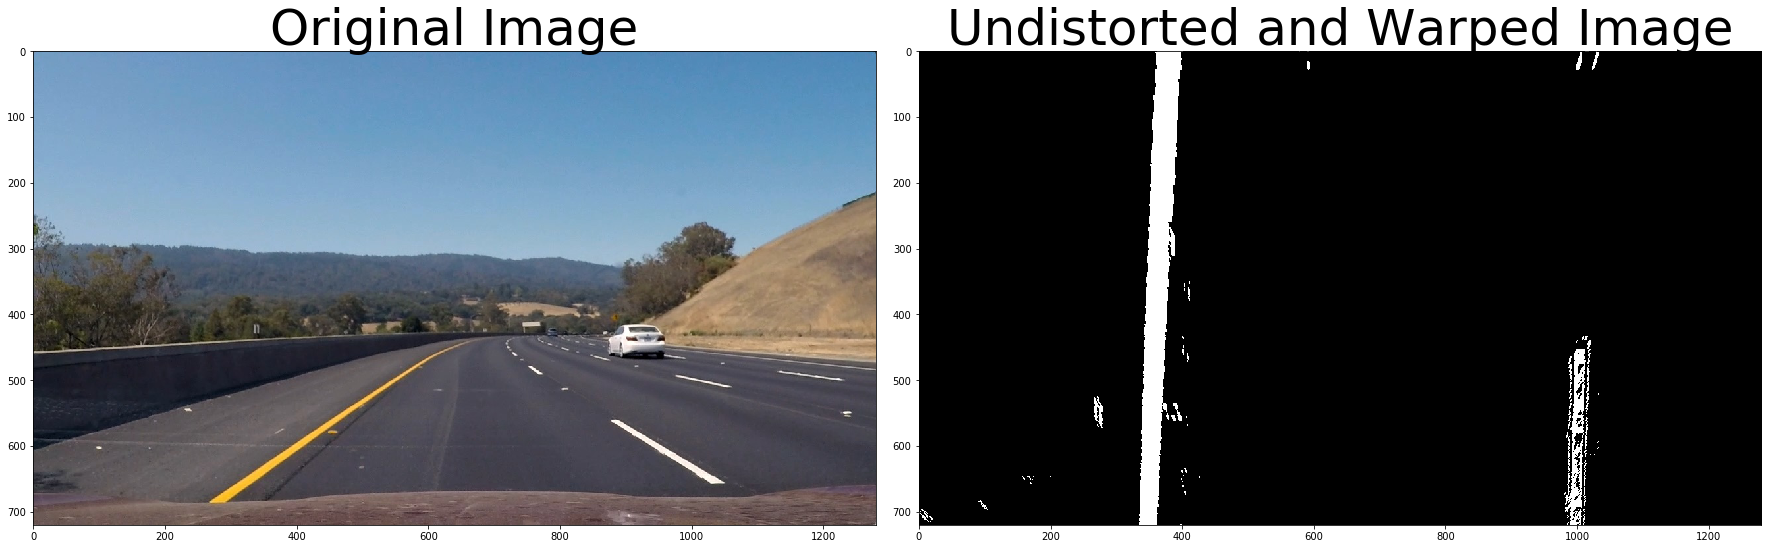

In [127]:
# Read another test image
test3_image = mpimg.imread(test_img_dir + 'test3.jpg')

# Undistort it
test3_img_undistort = undistort_img(test3_image, mtx, dist)

# Apply threshold
test3_img_threshold = pipeline(test3_img_undistort)

# Warp (perspective transform and apply thresholding)
test3_img_warped, Minv = warp_image(test3_img_threshold)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test3_image)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(test3_img_warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [128]:
# Use local area search to detect lane line pixels

def find_lane_lines_using_local_search(img, left_poly, right_poly):
    
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    margin = 100
    
    left_index = ( 
        (nonzerox > (left_poly[0]*(nonzeroy**2) + left_poly[1]*nonzeroy + left_poly[2] - margin) ) 
        & (nonzerox < (left_poly[0]*(nonzeroy**2) + left_poly[1]*nonzeroy + left_poly[2] + margin) ) )
    
    right_index = ( 
        (nonzerox > (right_poly[0]*(nonzeroy**2) + right_poly[1]*nonzeroy + right_poly[2] - margin) ) 
        & (nonzerox < (right_poly[0]*(nonzeroy**2) + right_poly[1]*nonzeroy + right_poly[2] + margin) ) )
    
    leftx = nonzerox[left_index]
    lefty = nonzeroy[left_index]
    
    rightx = nonzerox[right_index]
    righty = nonzeroy[right_index]
    
    # Fit a second order polynomial
    left_poly = np.polyfit(lefty, leftx, 2)
    right_poly = np.polyfit(righty, rightx, 2)
    
    # Generate x & y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    #Equation of second order polynomial
    left_poly_x = left_poly[0]*ploty**2 + left_poly[1]*ploty + left_poly[2]
    right_poly_x = right_poly[0]*ploty**2 + right_poly[1]*ploty + right_poly[2]
    
    
    # create an output image to work on
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    
    
    # Color the left and right image points to red and blue respectively
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    
    # Generate a polygon to illustrate search area
    left_line_window1 = np.array( [np.transpose(np.vstack([left_poly_x-margin, ploty]))] )
    left_line_window2 = np.array( [np.flipud(np.transpose(np.vstack([left_poly_x+margin, ploty])))] )
    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    
    right_line_window1 = np.array( [np.transpose(np.vstack([right_poly_x-margin, ploty]))] )
    right_line_window2 = np.array( [np.flipud(np.transpose(np.vstack([right_poly_x+margin, ploty])))] )
    
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    '''
    # Draw the lane lines box onto warped image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
    
    # Stack out_img with window_img
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.imshow(result)
    plt.plot(left_poly_x, ploty, color='yellow')
    plt.plot(right_poly_x, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    
    return ploty, left_poly, right_poly, leftx, lefty, rightx, righty, left_poly_x, right_poly_x

In [130]:
# Apply localized line search onto test3.jpg warped, thresholed, undistorted image
ploty, left_poly, right_poly, leftx, lefty, rightx, righty, left_poly_x, right_poly_x = find_lane_lines_using_local_search(test3_img_warped, left_poly, right_poly)

## Measuring Curvature

In [131]:
# Define y-value where we want radius of curvature
y_val = np.max(ploty)

left_curverad = ( ( 1 + (2*left_poly[0]*y_val + left_poly[1])**2 )**1.5 ) / np.absolute(2*left_poly[0])

right_curverad = ( ( 1 + (2*right_poly[0]*y_val + right_poly[1])**2 )**1.5 ) / np.absolute(2*right_poly[0])

print('Left curve pixel radius: {}'.format(left_curverad))
print('Right curve pixel radius: {}'.format(right_curverad))

Left curve pixel radius: 34388.37562285199
Right curve pixel radius: 28259.43738868096


In [132]:
# Convert pixel radius to meters

y_m_per_pixel = 30/720
x_m_per_pixel = 3.7/700

# Fit new polynomials in real world space
left_fit_cr = np.polyfit(lefty*y_m_per_pixel, leftx*x_m_per_pixel, 2)
right_fit_cr = np.polyfit(righty*y_m_per_pixel, rightx*x_m_per_pixel, 2)


left_curverad = ( ( 1 + (2*left_fit_cr[0]*y_val + left_fit_cr[1])**2 )**1.5 ) / np.absolute(2*left_fit_cr[0])

right_curverad = ( ( 1 + (2*right_fit_cr[0]*y_val + right_fit_cr[1])**2 )**1.5 ) / np.absolute(2*right_fit_cr[0])

print('Left curve radius: {}m'.format(left_curverad))
print('Right curve radius: {}m'.format(right_curverad))
print('Average curve radius: {}m'.format((right_curverad+left_curverad)/2))


Left curve radius: 11326.58618665149m
Right curve radius: 9348.676131367585m
Average curve radius: 10337.631159009537m


In [133]:
centerx = (np.absolute(left_poly_x[test3_img_warped.shape[0]-1] - right_poly_x[test3_img_warped.shape[0]-1]) / 2)
img_center = test3_img_warped.shape[1] / 2

offset = (np.absolute(centerx - img_center) * x_m_per_pixel)

if (centerx - img_center) <= 0:
    print("Vehicle is left of center by: {}m".format(offset))
else:
    print("Vehicle is right of center by: {}m".format(offset))
    

Vehicle is left of center by: 1.6683119895536014m


## Warp image back to original

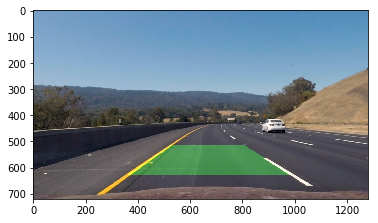

In [134]:
warp_zero = np.zeros_like(test3_img_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_poly_x, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_poly_x, ploty])))])

pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

newWarp = cv2.warpPerspective(color_warp, Minv, (test3_image.shape[1], test3_image.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(test3_img_undistort, 1, newWarp, 0.3, 0)
plt.imshow(result)

## Save video as frames

In [87]:
video_file = cv2.VideoCapture('project_video.mp4')

count = 0
ret = True

while ret:
    ret, img = video_file.read()
    cv2.imwrite("video_dir/frame%d.jpg" % count, img)
    count += 1

print("Wrote total {} frames.".format(count))

Wrote total 1261 frames.
